# Import

In [12]:
# Torch
from torch.utils.data import TensorDataset, DataLoader
import torch

import numpy as np
import scipy as sp

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

# Stable baselines
import gymnasium as gym
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback

# Custom modules
import sys
import os
local_path = '/Users/riccardo/Documents/GitHub/' #'path_to_progect_folder/'
sys.path.append(local_path+'OptimalControlAttacks/SyntheticDataExperiments/')
from Modules import AuxiliaryFunctions as AF
from Modules import GreedyAttacks as GA
from Parameters import ParametersAttacksComparison_LinearRegression as Par

# Colors

In [15]:
orange = '#F5A962'
light_blue = '#3C8DAD'

# Parameters

In [4]:
# Activation
activation = Par.activation

# Input data parameters
dim_input = Par.dim_input
batch_size = Par.batch_size
mu_x = Par.mu_x
sigma_x = Par.sigma_x
n_runs_experiments = Par.n_runs_experiments

# Dynamics parameters
learning_rate = Par.learning_rate
gamma = Par.gamma
beta = Par.beta

# N. samples
n_timesteps = Par.n_timesteps
n_timesteps_transient_th = Par.n_timesteps_transient_th
n_timesteps_past = Par.n_timesteps_past
n_samples_average = Par.n_samples_average
n_samples_buffer = Par.n_samples_buffer
n_samples_test = Par.n_samples_test
time_window = Par.time_window

# Control parameters
a_min = Par.a_min
a_max = Par.a_max
n_a_gridpoints = Par.n_a_gridpoints
n_runs_calibration = Par.n_runs_calibration
control_cost_weight = Par.control_cost_weight
greedy_weight_future = Par.greedy_weight_future
opt_pref = Par.opt_pref
fut_pref = Par.fut_pref

# DeepRL Agent
agent_model_name = Par.agent_model_name
n_actions = Par.n_actions
use_action_noise = Par.use_action_noise
action_noise_mean = Par.action_noise_mean
action_noise_std = Par.action_noise_std
use_small_achitecture = Par.use_small_achitecture
randomise_initial_condition = Par.randomise_initial_condition
shuffle_array = Par.shuffle_array
learning_rate_agent = Par.learning_rate_agent
activation_fn = Par.activation_fn
n_episodes = Par.n_episodes
save_freq = Par.save_freq
train_freq = Par.train_freq

# Strings/paths
experiment_description = Par.experiment_description
path_agent = Par.path_agent
export_path = Par.export_path
rlmodels_path = Par.rlmodels_path

In [5]:
print('dim_input:', dim_input)
print('batch_size:', batch_size)
print('activation:', activation)
print('a min:', a_min)
print('a max:', a_max)
print('control_cost_weight:', control_cost_weight)
print('N past timesteps:', n_timesteps_past)

dim_input: 10
batch_size: 1
activation: Linear
a min: -2
a max: 3
control_cost_weight: 1.0
N past timesteps: 40000


# Arrays

In [8]:
# Teacher
w_teach = np.ones(dim_input) #np.random.normal(0, 1, dim_input)
w_teach = w_teach/(np.sum(w_teach**2)/dim_input)**0.5
# Target
w_target = -w_teach
# Student (initial condition)
w_stud_0 = w_teach
            
# Arrays (assuming batch_size as specified above)
x_incoming_arr = np.random.normal(mu_x, sigma_x, (n_runs_experiments, batch_size*n_timesteps, dim_input))
x_past = np.random.normal(mu_x, sigma_x, (batch_size*n_timesteps_past, dim_input))
x_buffer = np.random.normal(mu_x, sigma_x, (batch_size*n_samples_buffer, dim_input))
x_test = np.random.normal(mu_x, sigma_x, (batch_size*n_samples_test, dim_input))

# Weight action cost

In [7]:
input_t_test = np.dot(w_teach, x_test.T)/(dim_input**0.5)
input_o_test = np.dot(w_target, x_test.T)/(dim_input**0.5)
label_t_test = GA.perceptron(input_t_test, activation=activation)
label_o_test = GA.perceptron(input_o_test, activation=activation)
error_target_teach = np.mean((label_o_test-label_t_test)**2)
d_target_teach = 0.5 * error_target_teach
pref_control_cost_weight = (2*d_target_teach)
print('Pre-factor control cost: %.2f' % pref_control_cost_weight)

Pre-factor control cost: 4.06


# Data poisoning environment

In [8]:
class Environment(gym.Env):

    def __init__(self, x_arr, batch_size, 
                 w_stud_0, w_teach, w_target, 
                 a_min, a_max, learning_rate,
                 control_cost_weight, 
                 activation='Erf', 
                 randomise_initial_condition=False, 
                 shuffle_array=False, 
                 time_window=500):
        
        super(Environment, self).__init__()

        # Input data to self
        self.dim_input = x_arr.shape[1]
        self.batch_size = batch_size
        self.n_timesteps = int(x_arr.shape[0]/batch_size)
        self.learning_rate = learning_rate 
        self.time_window = time_window
        self.control_cost_weight = control_cost_weight
        self.activation = activation
        self.w_teach = w_teach #.astype(np.float32)
        self.w_target = w_target #.astype(np.float32)        
        
        # Set time
        self.timestep = 0
        
        # Initialize the student
        self.randomise_initial_condition = randomise_initial_condition
        self.rho_grid = np.linspace(0.0, 1.0, 7)
        self.rho_idx = 0
        if randomise_initial_condition:
            np.random.shuffle(self.rho_grid)
            rho = self.rho_grid[self.rho_idx]
            self.w_stud_0 = self.w_teach * (1-rho) + self.w_target * rho
        else:
            self.w_stud_0 = w_stud_0 #.astype(np.float32)
        self.w_stud = self.w_stud_0
        
        # Data stream
        self.shuffle_array = shuffle_array
        if shuffle_array:
            np.random.shuffle(x_arr)
        self.x_arr = x_arr.astype(np.float32)
        self.x_batch = self.x_arr[self.timestep*self.batch_size:(self.timestep+1)*self.batch_size,:]
        self.x_batch_next = self.x_arr[(self.timestep+1)*self.batch_size:(self.timestep+2)*self.batch_size,:]
        
        # Define action and observation space
        self.a_min = a_min
        self.a_max = a_max
        self.action_space = gym.spaces.Box(low=self.a_min, high=self.a_max, shape=(1,), dtype=np.float32)
        high = 1e9 #np.inf
        self.observation_space = gym.spaces.Box(low=-high, high=high, shape=((1+self.batch_size)*self.dim_input,), dtype=np.float32)
        
        
    def reset(self, seed=0):
        # Re-initialise the student
        if self.randomise_initial_condition:
            if self.rho_idx<len(self.rho_grid)-1:
                self.rho_idx += 1
                rho = self.rho_grid[self.rho_idx]
            else:
                np.random.shuffle(self.rho_grid)
                self.rho_idx = 0
                rho = self.rho_grid[self.rho_idx]
            self.w_stud_0 = self.w_teach * (1-rho) + self.w_target * rho
        self.w_stud = self.w_stud_0
        # Shuffle array
        if self.shuffle_array:
            np.random.shuffle(self.x_arr)
        # Reset time
        self.timestep = 0
        # Reset batches
        self.x_batch = self.x_arr[self.timestep*self.batch_size:(self.timestep+1)*self.batch_size,:]
        self.x_batch_next = self.x_arr[(self.timestep+1)*self.batch_size:(self.timestep+2)*self.batch_size,:]
        return_info = {'Rand. initial condition': self.randomise_initial_condition,
                       'Shuffle input data': self.shuffle_array}
        return_obs = np.concatenate((self.w_stud.reshape(1,-1), self.x_batch), axis=0, dtype=np.float32).flatten() 
        return return_obs, return_info

    
    def perceptron(self, x):
        if self.activation=='Erf':
            output = sp.special.erf(x)
        elif self.activation=='ReLU':
            output = x * (x > 0)
        elif self.activation=='Linear':
            output = x
        else:
            raise ValueError('Supported activations are: Erf, ReLU, SReLU, Linear')
        return output
    
    
    def d_perceptron(self, x):
        if self.activation=='Erf':
            output = (2./np.sqrt(np.pi)) * np.exp(-x**2)
        elif self.activation=='ReLU':
            output = 1. * (x > 0)
        elif self.activation=='Linear':
            output = 1.
        else:
            raise ValueError('Supported activations are: Erf, ReLU, SReLU, Linear')
        return output
    
    
    def student_update(self, a):
        ''' Use update function defined in GreedyAttacks or Constant attacks '''
        w_stud_next = GA.student_update_perceptron(w_stud=self.w_stud, 
                                                   w_teach=self.w_teach,
                                                   w_target=self.w_target,
                                                   x_batch=self.x_batch, 
                                                   a=a, 
                                                   eta=self.learning_rate, 
                                                   dim_input=self.dim_input,
                                                   activation=self.activation)
        
        
        #a = np.atleast_1d(a)   

        '''
        # input values
        input_s = np.dot(self.w_stud, self.x_batch.T)/(self.dim_input**0.5)
        input_t = np.dot(self.w_teach, self.x_batch.T)/(self.dim_input**0.5)
        input_o = np.dot(self.w_target, self.x_batch.T)/(self.dim_input**0.5)
                
        if self.activation=='Erf':            
            activation_s = self.perceptron(input_s/(2**0.5))
            activation_t = self.perceptron(input_t/(2**0.5))
            activation_o = self.perceptron(input_o/(2**0.5))
            v1_0_factors = np.sqrt(1/(2*self.dim_input)) * (activation_s-activation_t) * self.d_perceptron(input_s/(2**0.5))
            v1_0 = v1_0_factors.reshape(-1, 1).repeat(self.dim_input, axis=1) * self.x_batch
            v1_0 = np.mean(v1_0, axis=0)
            v2_0_factors = np.sqrt(1/(2*dim_input)) * (activation_t-activation_o) * self.d_perceptron(input_s/(2**0.5))
            v2_0 = v2_0_factors.reshape(-1, 1).repeat(self.dim_input, axis=1) * self.x_batch
            v2_0 = np.mean(v2_0, axis=0)
        else:
            activation_s = self.perceptron(input_s)
            activation_t = self.perceptron(input_t)
            activation_o = self.perceptron(input_o)
            v1_0_factors = (1/np.sqrt(self.dim_input)) * (activation_s-activation_t) * self.d_perceptron(input_s)
            v1_0 = v1_0_factors.reshape(-1, 1).repeat(self.dim_input, axis=1) * self.x_batch
            v1_0 = np.mean(v1_0, axis=0)
            v2_0_factors = (1/np.sqrt(self.dim_input)) * (activation_t-activation_o) * self.d_perceptron(input_s)
            v2_0 = v2_0_factors.reshape(-1, 1).repeat(self.dim_input, axis=1) * self.x_batch
            v2_0 = np.mean(v2_0, axis=0)

        v1 = self.w_stud - self.learning_rate*v1_0
        v2 = - self.learning_rate*v2_0
        w_stud_next = v1 + a*v2
        '''

        return w_stud_next
    
    
    def step(self, action):
                
        # Perturbation cost
        per_cost = self.control_cost_weight * 0.5 * action**2
        
        # Nefarious cost
        input_s = np.dot(self.w_stud, self.x_batch.T)/(self.dim_input**0.5)
        input_o = np.dot(self.w_target, self.x_batch.T)/(self.dim_input**0.5)
        activation_s = GA.perceptron(input_s, activation=self.activation)
        activation_o = GA.perceptron(input_o, activation=self.activation)
        '''
        if self.activation=='Erf':
            activation_s = self.perceptron(input_s/(2**0.5))
            activation_o = self.perceptron(input_o/(2**0.5))
        else:
            activation_s = self.perceptron(input_s)
            activation_o = self.perceptron(input_o)
        '''
        nef_cost = 0.5 * np.mean((activation_s-activation_o)**2)
        
        # Update
        self.w_stud = self.student_update(action)
        self.timestep += 1
        self.x_batch = self.x_arr[self.timestep*self.batch_size:(self.timestep+1)*self.batch_size,:]
        self.x_batch_next = self.x_arr[(self.timestep+1)*self.batch_size:(self.timestep+2)*self.batch_size,:]
        
        # Total cost and reward
        total_cost = per_cost + nef_cost
        reward = float(-total_cost)

        # End episode flag
        terminated = bool(self.timestep > self.n_timesteps-2)
        truncated = False
        
        # Optionally we can pass additional info
        info = {'Action': action, 'Per. cost': per_cost, 'Nef cost': nef_cost}
        
        return_obs = np.concatenate((self.w_stud.reshape(1,-1), self.x_batch), axis=0, dtype=np.float32).flatten()

        return return_obs, reward, terminated, truncated, info

## Check environment

In [9]:
env = Environment(x_arr=x_past, batch_size=batch_size,
                  w_stud_0=w_stud_0, w_teach=w_teach, w_target=w_target, 
                  a_min=a_min, a_max=a_max, learning_rate=learning_rate, 
                  control_cost_weight=pref_control_cost_weight*control_cost_weight, 
                  activation=activation, shuffle_array=True, randomise_initial_condition=True)

In [10]:
check_env(env, warn=True)

/opt/anaconda3/envs/OptimalControlAttacks/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:428: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


# RL agent

In [11]:
# Try to load model
if use_small_achitecture:
    print('Using custom small architecture for policy and value!')
    if agent_model_name in ['TD3']:
        custom_net_kwargs = dict(activation_fn=activation_fn, net_arch=dict(pi=[10, 10], qf=[10, 10]))
else:
    custom_net_kwargs = None
         
        
if agent_model_name=='TD3':
        env = Environment(x_arr=x_past,
                         batch_size=batch_size,
                         w_stud_0=w_stud_0, 
                         w_teach=w_teach, 
                         w_target=w_target, 
                         a_min=a_min,
                         a_max=a_max,
                         learning_rate=learning_rate, 
                         control_cost_weight=pref_control_cost_weight*control_cost_weight, 
                         activation=activation, 
                         randomise_initial_condition=randomise_initial_condition, 
                         shuffle_array=shuffle_array)
        if use_action_noise:
            action_noise = NormalActionNoise(mean=action_noise_mean, sigma=action_noise_std)
        else:
            action_noise = None        
        model = TD3("MlpPolicy", 
                    env,
                    action_noise=action_noise,
                    verbose=0, 
                    gamma=gamma,
                    learning_rate=learning_rate_agent, 
                    policy_kwargs=custom_net_kwargs,
                    train_freq=train_freq, 
                    gradient_steps=train_freq)
        print('New %s agent created' % agent_model_name)
else:
    raise ValueError('Agent type other than TD3 not available/tested')
    
# print(model.policy)

New TD3 agent created


# Training agent

Real episodes have length n_past_timesteps. Nominal episodes can have any length, and simply refer to periods of training, where each period has 'timesteps' steps.

In [12]:
print('timesteps for each episode:', n_timesteps_past)

# Save a checkpoint 
checkpoint_callback = CheckpointCallback(
  save_freq=save_freq,
  save_path=path_agent,
  name_prefix="rl_model",
  save_replay_buffer=False,
  save_vecnormalize=True,
)

for ep in range(n_episodes):
    print('Episode: %d/%d'%(ep+1, n_episodes))
    model.learn(total_timesteps=n_timesteps_past, 
                progress_bar=False, 
                reset_num_timesteps=False,
                tb_log_name='DeepRL', 
                log_interval=1, 
                callback=checkpoint_callback)
        
print('Training completed!')

timesteps for each episode: 40000
Episode: 1/8
Episode: 2/8
Episode: 3/8
Episode: 4/8
Episode: 5/8
Episode: 6/8
Episode: 7/8
Episode: 8/8
Training completed!


## Compute training performance

In [58]:
timesteps = n_timesteps_past

steps = []
rew_disc_av = []
experiment_idx = 0
w_stud_0_test = w_stud_0

for ep in range(n_episodes):
    
    for t in range(0, timesteps+1, 4*save_freq):
        
        timesteps_past = ep*timesteps + t
        steps_flag = False

        if agent_model_name=='TD3':
            path_to_model = path_agent + f'/rl_model_{timesteps_past}_steps.zip'
            #path_to_buffer = path_repbuffer + f'rl_model_replay_buffer_{timesteps_past}_steps.pkl'
            if os.path.exists(path_to_model):
                model_iter = TD3.load(path_to_model, env)
                #model_iter.load_replay_buffer(path_to_buffer)
                print('%d (ep %d)' % (timesteps_past, ep+1)) 
                steps_flag = True
            else:
                print('  %d-model not found (ep %d)' % (timesteps_past, ep+1)) 

        if steps_flag:
            reward_list = []
            env = Environment(x_arr=x_test,
                             batch_size=batch_size,
                             w_stud_0=w_stud_0, 
                             w_teach=w_teach, 
                             w_target=w_target, 
                             a_min=a_min,
                             a_max=a_max,
                             learning_rate=learning_rate, 
                             control_cost_weight=pref_control_cost_weight*control_cost_weight, 
                             activation=activation, 
                             randomise_initial_condition=randomise_initial_condition, 
                             shuffle_array=shuffle_array)

            obs, info = env.reset()
            terminated = False
            while not terminated:
                action, _ = model_iter.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = env.step(action)
                if env.timestep>=n_timesteps - time_window:
                    reward_list.append(reward)
                    
            rew_disc_av.append(np.mean(np.array(reward_list, dtype=object)))
            steps.append(timesteps_past)
        
objective = -np.array(rew_disc_av, dtype=object)
steps = np.array(steps, dtype=object)

  0-model not found (ep 1)
4000 (ep 1)
8000 (ep 1)
12000 (ep 1)
16000 (ep 1)
20000 (ep 1)
24000 (ep 1)
28000 (ep 1)
32000 (ep 1)
36000 (ep 1)
40000 (ep 1)
40000 (ep 2)
44000 (ep 2)
48000 (ep 2)
52000 (ep 2)
56000 (ep 2)
60000 (ep 2)
64000 (ep 2)
68000 (ep 2)
72000 (ep 2)
76000 (ep 2)
80000 (ep 2)
80000 (ep 3)
84000 (ep 3)
88000 (ep 3)
92000 (ep 3)
96000 (ep 3)
100000 (ep 3)
104000 (ep 3)
108000 (ep 3)
112000 (ep 3)
116000 (ep 3)
120000 (ep 3)
120000 (ep 4)
124000 (ep 4)
128000 (ep 4)
132000 (ep 4)
136000 (ep 4)
140000 (ep 4)
144000 (ep 4)
148000 (ep 4)
152000 (ep 4)
156000 (ep 4)
160000 (ep 4)
160000 (ep 5)
164000 (ep 5)
168000 (ep 5)
172000 (ep 5)
176000 (ep 5)
180000 (ep 5)
184000 (ep 5)
188000 (ep 5)
192000 (ep 5)
196000 (ep 5)
200000 (ep 5)
200000 (ep 6)
204000 (ep 6)
208000 (ep 6)
212000 (ep 6)
216000 (ep 6)
220000 (ep 6)
224000 (ep 6)
228000 (ep 6)
232000 (ep 6)
236000 (ep 6)
240000 (ep 6)
240000 (ep 7)
244000 (ep 7)
248000 (ep 7)
252000 (ep 7)
256000 (ep 7)
260000 (ep 7)
264000 

In [59]:
objective

array([25.5404628033638, 2.0393909637633576, 1.0143767678334916,
       0.8740958198685912, 0.7942680069395174, 0.818462787117509,
       0.7302538298493788, 0.7065837287471561, 0.6894139634296226,
       0.671390031724819, 0.6721516767295789, 0.6692666540156976,
       0.6750339026028402, 0.687079596274922, 0.690670861030864,
       0.6552521419958953, 0.6625715328285178, 0.6387747103480368,
       0.6798162958236392, 0.6539093599293362, 0.676842334390527,
       0.674613775219778, 0.6283773723543673, 0.6398859494292896,
       0.6554639318322201, 0.703970660000837, 0.6718926236691974,
       0.6590866127756017, 0.6479541771642762, 0.6285544076895506,
       0.6502486555510076, 0.6142348549104802, 0.6158249744458093,
       0.64015916791242, 0.7234273745918699, 0.6563639716376062,
       0.597974612681742, 0.608498095932051, 0.6151564779290181,
       0.6003143027644467, 0.5988915450981691, 0.6026469138022404,
       0.6192872572361526, 0.6128269144669951, 0.6165031818885021,
       0

## Export training performance

In [52]:
models_description = '_agent#%s' % (agent_model_name)
name = 'ObjectiveVSTrainingSteps'
filename = name + '_@@@' + models_description + experiment_description
data_to_export = objective
np.save(rlmodels_path + filename, data_to_export)


models_description = '_agent#%s' % (agent_model_name)
name = 'TrainingSteps'
filename = name + '_@@@' + models_description + experiment_description
data_to_export = steps
np.save(rlmodels_path + filename, data_to_export)

## Plot training performance

In [62]:
# Greedy average reward
if activation=='Linear':
    pref_fut = 1.
elif activation=='Erf':
    pref_fut = 2.
reward_greedy_list = []

index_experiment = 0
env = Environment(x_arr=x_test,
                  batch_size=batch_size,
                  w_stud_0=w_stud_0, 
                  w_teach=w_teach, 
                  w_target=w_target, 
                  a_min=a_min,
                  a_max=a_max,
                  learning_rate=learning_rate, 
                  control_cost_weight=pref_control_cost_weight*control_cost_weight, 
                  activation=activation, 
                  randomise_initial_condition=randomise_initial_condition, 
                  shuffle_array=shuffle_array)

obs, info = env.reset()
w_stud = env.w_stud
x_batch = env.x_batch

terminated = False
while not terminated:    
    action = GA.a_greedy_perceptron(w_stud=w_stud,
                                    w_target=w_target,
                                    w_teach=w_teach,
                                    x_batch=x_batch,
                                    x_buffer=x_buffer,
                                    dim_input=dim_input,
                                    eta=learning_rate,
                                    weight_future=pref_fut*dim_input/learning_rate,
                                    a_min=a_min,
                                    a_max=a_max,
                                    control_cost_weight=pref_control_cost_weight*control_cost_weight,
                                    activation=activation)
    
    obs, reward, terminated, truncated, info = env.step(action)
    w_stud = env.w_stud
    x_batch = env.x_batch
    if env.timestep>=n_timesteps - time_window:
        reward_greedy_list.append(reward)
    
objective_greedy = -np.mean(np.array(reward_greedy_list, dtype=object))
objective_greedy, env.timestep

(0.5788123743397624, 9999)

In [53]:
best_model_t = steps[np.argmin(objective)]
best_model_obj = objective[np.argmin(objective)]
best_model_t, best_model_obj

(312000, 0.6179872598415139)

In [64]:
objective_copy = objective.copy()

In [16]:
AF.SetPlotParams(magnification=.9, ratio=float(2.2/3.), fontsize=11, lines_w=.7, ms=7)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')


plt.axhline(objective_greedy, color='black', ls=':', lw=.8, label='greedy')
plt.plot(steps+1, objective, color=orange)
plt.plot(best_model_t, best_model_obj, color=light_blue, ls='', marker='.', ms=8)

plt.ylabel('$g^{\mathrm{RL}}_{\infty}$')
plt.xlabel('n. episodes')
plt.xlim([-10000, 320000])
x_positions_ticks = np.linspace(0, 8, 5)*n_timesteps_past
x_ticks_labels = [int(x) for x in np.linspace(0, 8, 5)]
plt.xticks(x_positions_ticks, x_ticks_labels)
#plt.yticks([0.3, 0.5, 0.7])
plt.yticks([0.5, 1, 1.5, 2])
plt.ylim([0.5, 2.])
#plt.yscale('log')
plt.grid(False)
plt.legend(loc=0)
plt.show()

NameError: name 'objective_greedy' is not defined

# Test experiment

In [66]:
# Choose model
timesteps_past = best_model_t
if agent_model_name=='TD3':
    path_to_model = path_agent + f'/rl_model_{timesteps_past}_steps.zip'
    #path_to_buffer = path_repbuffer + f'rl_model_replay_buffer_{timesteps_past}_steps.pkl'
    if os.path.exists(path_to_model):
        model_iter = TD3.load(path_to_model, env)
        #model_iter.load_replay_buffer(path_to_buffer)
        print('%d (ep %d)' % (timesteps_past, ep+1)) 
        steps_flag = True
    else:
        print('  %d-model not found (ep %d)' % (timesteps_past, ep+1)) 

296000 (ep 8)


In [76]:
w_stud_DRLAgent_dynamics = []
w_stud_greedy_dynamics = []
a_DRLAgent_dynamics = []
a_greedy_dynamics = []

w_stud_0_test = w_stud_0 #np.zeros_like(w_stud_0) #w_stud_0

experiment_idx = 0
shuffle_array_local = False
randomise_initial_condition_local = False

## Greedy ##
env_greedy = Environment(x_arr=x_incoming_arr[experiment_idx],
                         batch_size=batch_size,
                         w_stud_0=w_stud_0_test, 
                         w_teach=w_teach, 
                         w_target=w_target, 
                         a_min=a_min,
                         a_max=a_max,
                         learning_rate=learning_rate, 
                         control_cost_weight=pref_control_cost_weight*control_cost_weight, 
                         activation=activation, 
                         randomise_initial_condition=randomise_initial_condition_local, 
                         shuffle_array=shuffle_array_local)
obs_greedy, _ = env_greedy.reset()
w_stud_greedy = env_greedy.w_stud
w_stud_greedy_dynamics.append(w_stud_greedy)
x_batch_greedy = env_greedy.x_batch

## DeepRL ##
env_DRLAgent = Environment(x_arr=x_incoming_arr[experiment_idx],
                          batch_size=batch_size,
                          w_stud_0=w_stud_0_test, 
                          w_teach=w_teach, 
                          w_target=w_target, 
                          a_min=a_min,
                          a_max=a_max,
                          learning_rate=learning_rate, 
                          control_cost_weight=pref_control_cost_weight*control_cost_weight, 
                          activation=activation, 
                          randomise_initial_condition=randomise_initial_condition_local, 
                          shuffle_array=shuffle_array_local)
obs_DRLAgent, _ = env_DRLAgent.reset()
w_stud_DRLAgent = env_DRLAgent.w_stud
w_stud_DRLAgent_dynamics.append(w_stud_DRLAgent)


n_timesteps_local = n_timesteps
for step in range(n_timesteps_local):
    ## Greedy ##
    action_greedy = GA.a_greedy_perceptron(w_stud=w_stud_greedy,
                                           w_target=w_target,
                                           w_teach=w_teach,
                                           x_batch=x_batch_greedy,
                                           x_buffer=x_buffer,
                                           dim_input=dim_input,
                                           eta=learning_rate,
                                           weight_future=pref_fut*dim_input/learning_rate,
                                           a_min=a_min,
                                           a_max=a_max,
                                           control_cost_weight=pref_control_cost_weight*control_cost_weight,
                                           activation=activation)
    a_greedy_dynamics.append(action_greedy)
    obs_greedy, reward_greedy, done_greedy, truncated_greedy, info_greedy = env_greedy.step(action_greedy)
    w_stud_greedy = env_greedy.w_stud
    x_batch_greedy = env_greedy.x_batch

    
    ## DeepRL ##
    action_DRLAgent, _ = model_iter.predict(obs_DRLAgent, deterministic=True)
    a_DRLAgent_dynamics.append(action_DRLAgent)
    obs_DRLAgent, reward_DRLAgent, done_DRLAgent, truncated_DRLAgent, info_DRLAgent = env_DRLAgent.step(action_DRLAgent)
    w_stud_DRLAgent = env_DRLAgent.w_stud
    
    
    ## Check end ##
    if done_DRLAgent or step==n_timesteps_local-1:
        print("Time up!", "reward=", reward)
        break
    
    
    w_stud_greedy_dynamics.append(w_stud_greedy)
    w_stud_DRLAgent_dynamics.append(w_stud_DRLAgent)
    
    
    
w_stud_greedy_dynamics = np.array(w_stud_greedy_dynamics)
a_greedy_dynamics = np.array(a_greedy_dynamics)

w_stud_DRLAgent_dynamics = np.array(w_stud_DRLAgent_dynamics)
a_DRLAgent_dynamics = np.array(a_DRLAgent_dynamics)

Time up! reward= -2.6048212664838677


## Plot overlap

## Plot policy

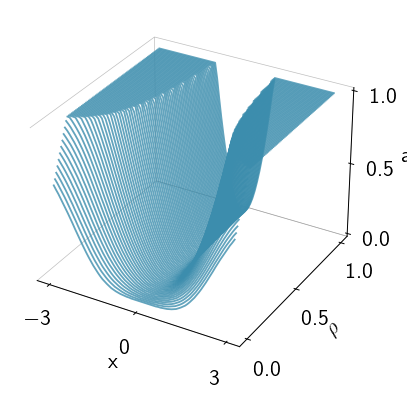

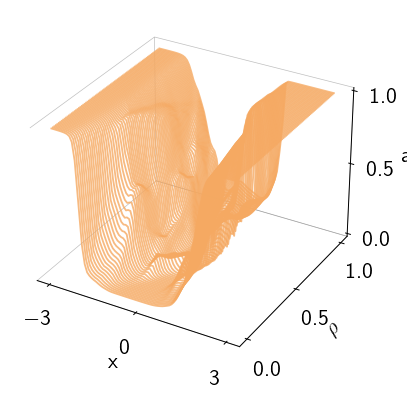

In [95]:
# 3D plot
AF.SetPlotParams(magnification=2.2, ratio=float(2.2/3.), fontsize=16, lines_w=1.3, ms=7)

alpha = 0.8

#print('Greedy policy')
ax = plt.figure().add_subplot(projection='3d')

x = x_grid
for j, rho in enumerate(rho_grid):
    y = 1-rho * np.ones_like(x)
    z = a_greedy_grid_2D[j]
    ax.plot(x, y, z, color=light_blue, alpha=alpha)
    #z = a_DeepRL_grid_2D[j]
    #ax.plot(x, y, z, color=orange, alpha=alpha)
    ax.set(xlabel='x', ylabel='$\\rho$', zlabel='a')
    ax.set_zlabel('a')
    #ax.set_title('Greedy policy', fontsize=16)
#ax.legend()

ax.set_xticks([-3, 0, 3])
ax.set_yticks([0, 0.5, 1])
ax.set_zticks([0, 0.5, 1])

# Remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Set color of edges
ax.xaxis.pane.set_edgecolor('grey')
ax.yaxis.pane.set_edgecolor('grey')
ax.zaxis.pane.set_edgecolor('grey')
ax.grid(False)

filename = 'Policy1DGreedy#%s.pdf' % activation
plt.savefig(path_figures + filename, bbox_inches='tight')

azim = -60
elev = 30
#ax.azim = azim
#ax.elev = elev

plt.show()


#print('%s policy ep. %d' % (agent_model_name, n_episodes))
ax = plt.figure().add_subplot(projection='3d')

for j, rho in enumerate(rho_grid):
    y = 1-rho * np.ones_like(x)
    #z = a_greedy_grid_2D[j]
    #ax.plot(x, y, z, color=light_blue, alpha=alpha)
    z = a_DeepRL_grid_2D[j]
    ax.plot(x, y, z, color=orange, alpha=alpha)
    ax.set(xlabel='x', ylabel='$\\rho$', zlabel='a')
    ax.set_zlabel('a')
    #ax.set_title('%s policy, steps %d' % (agent_model_name, model_steps), fontsize=16)
#ax.legend()


ax.set_xticks([-3, 0, 3])
ax.set_yticks([0, 0.5, 1])
ax.set_zticks([0, 0.5, 1])

# Remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Set color of edges
ax.xaxis.pane.set_edgecolor('grey')
ax.yaxis.pane.set_edgecolor('grey')
ax.zaxis.pane.set_edgecolor('grey')
ax.grid(False)
#ax.azim = azim
#ax.elev = elev

filename = 'Policy1DRL#%s.pdf' % activation
plt.savefig(path_figures + filename, bbox_inches='tight')

plt.show()

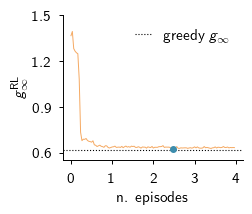

In [93]:
if dim_input==1 and batch_size==1:

    AF.SetPlotParams(magnification=.8, ratio=float(2.2/2.7), fontsize=11, lines_w=.7, ms=7)
    mpl.rcParams['axes.spines.right'] = False
    mpl.rcParams['axes.spines.top'] = False
    mpl.rc('text', usetex = True)
    mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
    
    x = np.arange(120)
    plt.axhline(objective_greedy, color='black', ls=':', lw=.8, label='greedy $g_{\infty}$')
    plt.plot(1000*x+1, objective[x], color=orange)
    plt.plot(best_model_t, best_model_obj, color=light_blue, ls='', marker='.', ms=8)

    plt.ylabel('$g^{\mathrm{RL}}_{\infty}$')
    plt.xlabel('n. episodes')
    #plt.xlim([-10000, 320000])
    x_positions_ticks = np.linspace(0, 4, 5)*30000
    x_ticks_labels = [int(x) for x in np.linspace(0, 4, 5)]
    plt.xticks(x_positions_ticks, x_ticks_labels)
    plt.yticks([0.6, 0.9, 1.2, 1.5])
    #plt.yticks([0.5, 1, 1.5, 2])
    plt.ylim([0.55, 1.5])
    plt.grid(False)
    plt.legend(loc=0)
    filename = '1DRLTrainingRunningCostSS_Perceptron#%s.pdf' % activation
    plt.savefig(path_figures + filename, bbox_inches='tight')
    plt.show()